In [39]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

df=pd.read_csv('~/Desktop/googleflu 1.csv')

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [40]:
df['ds']=pd.to_datetime(df['Date'])
df['y']=df['United States']
df.head()

,Date,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,"Norfolk, VA","Reston, VA","Richmond, VA","Bellevue, WA","Seattle, WA","Spokane, WA","Madison, WI","Milwaukee, WI",ds,y
0,2003-09-28,902,477,nan,606,nan,929,233,223,nan,...,948,nan,1035,nan,668,nan,622,452,2003-09-28,902
1,2003-10-05,952,501,nan,663,nan,849,251,243,nan,...,963,nan,1135,nan,787,nan,626,449,2003-10-05,952
2,2003-10-12,1092,492,nan,700,nan,1032,283,261,nan,...,970,nan,1170,nan,994,nan,661,437,2003-10-12,1092
3,2003-10-19,1209,533,nan,819,nan,1084,310,268,nan,...,1011,nan,1342,nan,999,nan,649,487,2003-10-19,1209
4,2003-10-26,1249,594,nan,959,nan,989,344,334,nan,...,1009,nan,1354,nan,1297,nan,657,499,2003-10-26,1249


In [41]:
df_flu = df[['Date', 'United States']]
df_flu.head()

,Date,United States
0,2003-09-28,902
1,2003-10-05,952
2,2003-10-12,1092
3,2003-10-19,1209
4,2003-10-26,1249


In [42]:
df_flu['Date'] = pd.to_datetime(df_flu['Date'])
df_flu.head()

,Date,United States
0,2003-09-28,902
1,2003-10-05,952
2,2003-10-12,1092
3,2003-10-19,1209
4,2003-10-26,1249


In [43]:
df_flu= df_flu.set_index(pd.DatetimeIndex(df_flu['Date']))

In [44]:
valid_start_dt = '2013-09-01 00:00:00'
test_start_dt = '2014-09-01 00:00:00'

In [45]:
T = 6
HORIZON = 1

In [46]:
train = df_flu.loc[df_flu.index<valid_start_dt, 'United States'].to_frame('United States')
train.head()

,United States
Date,
2003-09-28,902
2003-10-05,952
2003-10-12,1092
2003-10-19,1209
2003-10-26,1249


In [47]:
scaler = MinMaxScaler()
train['United States'] = scaler.fit_transform(train)
train.head(10)

,United States
Date,
2003-09-28,0.03
2003-10-05,0.04
2003-10-12,0.05
2003-10-19,0.06
2003-10-26,0.07
2003-11-02,0.08
2003-11-09,0.11
2003-11-16,0.16
2003-11-23,0.24


In [48]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['United States'].shift(-1, freq='W')
for t in range(1, T+1):
    train_shifted['United States'+str(T-t)] = train_shifted['United States'].shift(T-t, freq='W')
y_col = 'y_t+1'
X_cols = ['flu_t-5',
             'flu_t-4',
             'flu_t-3',
             'flu_t-2',
             'flu_t-1',
             'flu_t']
train_shifted.columns = ['flu_original']+[y_col]+X_cols

In [49]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,flu_original,y_t+1,flu_t-5,flu_t-4,flu_t-3,flu_t-2,flu_t-1,flu_t
Date,,,,,,,,
2003-11-02,0.08,0.11,0.03,0.04,0.05,0.06,0.07,0.08
2003-11-09,0.11,0.16,0.04,0.05,0.06,0.07,0.08,0.11
2003-11-16,0.16,0.24,0.05,0.06,0.07,0.08,0.11,0.16
2003-11-23,0.24,0.30,0.06,0.07,0.08,0.11,0.16,0.24
2003-11-30,0.30,0.48,0.07,0.08,0.11,0.16,0.24,0.30


In [50]:
y_train = train_shifted[y_col].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

In [51]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [52]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df_flu.loc[df_flu.index<test_start_dt, 'United States'].to_frame('United States')
valid.head()

,United States
Date,
2003-09-28,902
2003-10-05,952
2003-10-12,1092
2003-10-19,1209
2003-10-26,1249


In [53]:
valid['Texas'] = scaler.transform(valid)
valid.head()

,United States,Texas
Date,,
2003-09-28,902,0.03
2003-10-05,952,0.04
2003-10-12,1092,0.05
2003-10-19,1209,0.06
2003-10-26,1249,0.07


In [54]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['United States'].shift(-1, freq='W')
for t in range(1, T+1):
    valid_shifted['United States'+str(T-t)] = valid_shifted['United States'].shift(T-t, freq='W')
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,United States,Texas,y+1,United States5,United States4,United States3,United States2,United States1,United States0
Date,,,,,,,,,
2003-11-02,1374,0.08,"1,702.00",902.00,952.00,"1,092.00","1,209.00","1,249.00",1374
2003-11-09,1702,0.11,"2,148.00",952.00,"1,092.00","1,209.00","1,249.00","1,374.00",1702
2003-11-16,2148,0.16,"2,968.00","1,092.00","1,209.00","1,249.00","1,374.00","1,702.00",2148


In [55]:
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['United States'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [56]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [57]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

In [58]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [59]:
y_valid.shape

(565,)

In [60]:
X_valid[:3]

array([[[ 902.],
        [ 952.],
        [1092.],
        [1209.],
        [1249.],
        [1374.]],

       [[ 952.],
        [1092.],
        [1209.],
        [1249.],
        [1374.],
        [1702.]],

       [[1092.],
        [1209.],
        [1249.],
        [1374.],
        [1702.],
        [2148.]]])

In [61]:
X_valid.shape

(565, 6, 1)

In [62]:
X_valid[:3]

array([[[ 902.],
        [ 952.],
        [1092.],
        [1209.],
        [1249.],
        [1374.]],

       [[ 952.],
        [1092.],
        [1209.],
        [1249.],
        [1374.],
        [1702.]],

       [[1092.],
        [1209.],
        [1249.],
        [1374.],
        [1702.],
        [2148.]]])

In [63]:
model.compile(optimizer='RMSprop', loss='mse')

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [65]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)

In [66]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 512 samples, validate on 565 samples
Epoch 1/50
512/512 [==============================] - 4s 8ms/step - loss: 0.0453 - val_loss: 5198911.2577
Epoch 2/50
512/512 [==============================] - 0s 461us/step - loss: 0.0341 - val_loss: 5198774.1881
Epoch 3/50
512/512 [==============================] - 0s 493us/step - loss: 0.0276 - val_loss: 5198655.9597
Epoch 4/50
512/512 [==============================] - 0s 837us/step - loss: 0.0241 - val_loss: 5198096.1779
Epoch 5/50
512/512 [==============================] - 0s 563us/step - loss: 0.0220 - val_loss: 5197933.2221
Epoch 6/50
512/512 [==============================] - 0s 622us/step - loss: 0.0204 - val_loss: 5197793.2319
Epoch 7/50
512/512 [==============================] - 0s 522us/step - loss: 0.0191 - val_loss: 5197670.4106
Epoch 8/50
512/512 [==============================] - 0s 565us/step - loss: 0.0176 - val_loss: 5197538.7312
Epoch 9/50
512/512 [==============================] - 0s 526us/step - loss: 0.0161 - val_los

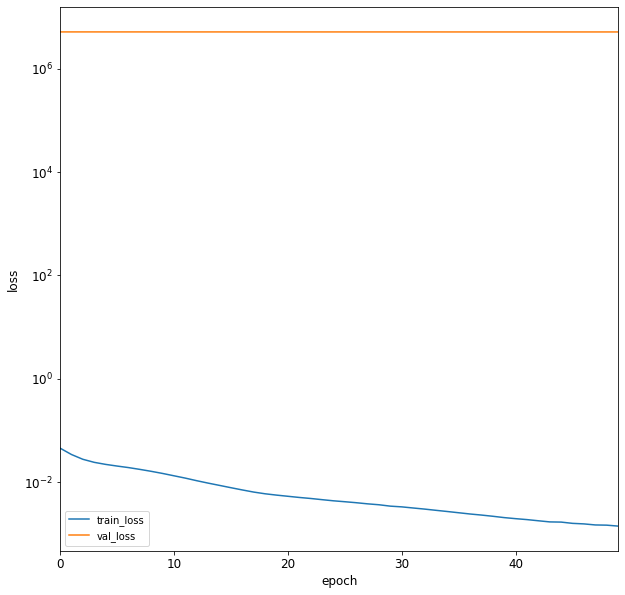

In [67]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [68]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df_flu.copy()[test_start_dt:][['United States']]
test['United States'] = scaler.transform(test)
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['United States'].shift(-1, freq='W')
for t in range(1, T+1):
    test_shifted['United States'+str(T-t)] = test_shifted['United States'].shift(T-t, freq='W')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['United States'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [69]:
predictions = model.predict(X_test)
predictions

array([[0.08],
       [0.08],
       [0.08],
       [0.08],
       [0.08],
       [0.1 ],
       [0.12],
       [0.17],
       [0.24],
       [0.43],
       [0.63],
       [0.62],
       [0.42],
       [0.3 ],
       [0.31],
       [0.31],
       [0.27],
       [0.25],
       [0.21],
       [0.19],
       [0.16],
       [0.17],
       [0.15],
       [0.14],
       [0.13],
       [0.11],
       [0.1 ],
       [0.07],
       [0.07],
       [0.08],
       [0.07],
       [0.06],
       [0.06],
       [0.06],
       [0.06],
       [0.04],
       [0.03],
       [0.04],
       [0.05],
       [0.04],
       [0.03],
       [0.01],
       [0.01]], dtype=float32)

In [70]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-10-12,t+1,"1,386.54","1,349.00"
1,2014-10-19,t+1,"1,416.39","1,224.00"
2,2014-10-26,t+1,"1,336.05","1,374.00"
3,2014-11-02,t+1,"1,375.02","1,379.00"
4,2014-11-09,t+1,"1,410.59","1,549.00"


In [71]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [72]:
mape(eval_df['prediction'], eval_df['actual'])

0.13491504911992025

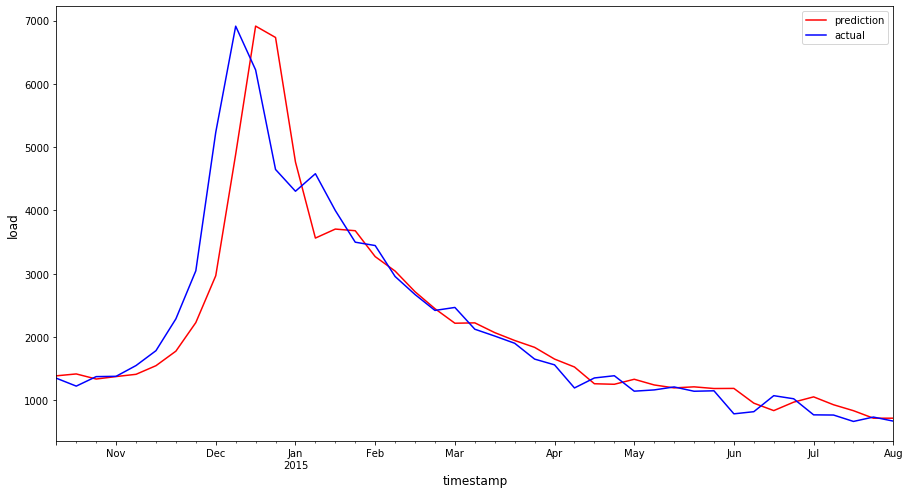

In [73]:
eval_df[eval_df.timestamp<'2016-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [74]:
pd.__version__

'0.25.1'

In [75]:
df=pd.read_csv('~/Desktop/googleflu 1.csv')
df.head()

,Date,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,"Salt Lake City, UT","Arlington, VA","Norfolk, VA","Reston, VA","Richmond, VA","Bellevue, WA","Seattle, WA","Spokane, WA","Madison, WI","Milwaukee, WI"
0,2003-09-28,902,477,nan,606,nan,929,233,223,nan,...,261,1066,948,nan,1035,nan,668,nan,622,452
1,2003-10-05,952,501,nan,663,nan,849,251,243,nan,...,249,1249,963,nan,1135,nan,787,nan,626,449
2,2003-10-12,1092,492,nan,700,nan,1032,283,261,nan,...,295,1289,970,nan,1170,nan,994,nan,661,437
3,2003-10-19,1209,533,nan,819,nan,1084,310,268,nan,...,292,1308,1011,nan,1342,nan,999,nan,649,487
4,2003-10-26,1249,594,nan,959,nan,989,344,334,nan,...,328,1426,1009,nan,1354,nan,1297,nan,657,499
